# Build a Question Answering application over a Graph Database

# 1. Install necessary dependencies

In [136]:
%pip install --upgrade --quiet langchain langchain-neo4j langchain-openai langgraph

In [137]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
# os.environ["LANGSMITH_TRACING"] = "true"

In [138]:
os.environ["NEO4J_URI"] = "neo4j+s://01685918.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "VDcktQ6eWGXbZ2pMPCBjxFQGpej-ZfBoevKTbAQ0tsQ"

# 2. Loading the movies dataset to Neo4j DB

a. Import necessary dependencies

b. Creating a Neo4jGraph Instance

c. Defining the Cypher Query (movies_query)

1. This multi-line string contains a Cypher query that will be executed against the Neo4j database.
2. LOAD CSV WITH HEADERS FROM ...: This Cypher clause loads data from a CSV file hosted on GitHub.
3. AS row: This assigns each row of the CSV file to the variable row.
4. MERGE (m:Movie {id:row.movieId}): This creates or updates a Movie node in the graph. MERGE ensures that a node with the specified id (which is the movieId from the CSV) is created only if it doesn't already exist.
5. SET m.released = date(row.released), m.title = row.title, m.imdbRating = toFloat(row.imdbRating): This sets properties on the Movie node:

m.released: The release date, converted to a Neo4j date type.

m.title: The movie title.

m.imdbRating: The IMDb rating, converted to a floating-point number.

6. FOREACH (director in split(row.director, '|') | ...): This iterates through the directors listed in the director column (which can contain multiple directors separated by |).

MERGE (p:Person {name:trim(director)}): Creates or updates a Person node for each director.

MERGE (p)-[:DIRECTED]->(m): Creates a DIRECTED relationship from the Person node to the Movie node.

7. FOREACH (actor in split(row.actors, '|') | ...): This does the same for actors, creating Person nodes and ACTED_IN relationships.
8. FOREACH (genre in split(row.genres, '|') | ...): This does the same for genres, creating Genre nodes and IN_GENRE relationships.

d. Executing the Cypher Query

Summary

This code connects to a Neo4j database, loads movie data from a CSV file, and creates a graph structure representing movies, people (directors and actors), and genres, with relationships between them. The MERGE operation is used to prevent duplicate nodes, and FOREACH is used to handle multi-valued columns in the CSV.

In [139]:
from langchain_neo4j import Neo4jGraph

graph = Neo4jGraph()

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

# 3. Graph schema

### Print the current Schema

This code snippet refreshes the schema information of a Neo4j graph database using LangChain's Neo4jGraph and then prints the schema to the console. This is useful for:

Inspecting the graph's structure: Understanding the nodes, relationships, and properties that exist in the graph.
Verifying schema changes: Ensuring that any changes made to the graph have been correctly reflected in the schema.
Providing context to LangChain agents: Allowing agents to understand the graph's structure and generate appropriate Cypher queries.

In [140]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Movie {id: STRING, released: DATE, title: STRING, imdbRating: FLOAT}
Person {name: STRING}
Genre {name: STRING}
Chunk {id: STRING, embedding: LIST, text: STRING, question: STRING, query: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


### Enhanced Schema

In [141]:
enhanced_graph = Neo4jGraph(enhanced_schema=True)
print(enhanced_graph.schema)

Node properties:
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
- **Chunk**
  - `id`: STRING Available options: ['d66006059fd78d63f3df90cc1059639a', '0e3dcb4502853979d12357690a95ec17', 'c438c6bcdcf8e4fab227f29f8e7ff204', '97fe701ec38057594464beaa2df0710e', 'b54f9286e684373498c4504b4edd9910', '5b50a72c3a4954b0ff7a0421be4f99b9', 'fb28d41771e717255f0d8f6c799ede32', '58e6f14dd2e6c6702cf333f2335c499c']
  - `text`: STRING Available options: ['How many artists are there?', 'Which actors played in the movie Casino?', 'How many movies has Tom Hanks acted in?', "List all the genres of the movie Schindler's List", 'Which actors have worked in movies from both the c', 'Which directors have made movies with at least thr', 'Identify movies where directors also p

# 4. Leveraging out of the box GraphQACypherChain

### GraphQACypherChain

simple out-of-the-box chain that takes a question, turns it into a Cypher query, executes the query, and uses the result to answer the original question.

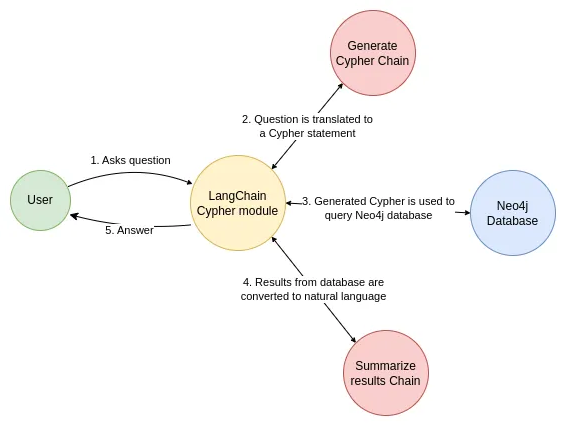

In [142]:
from langchain_neo4j import GraphCypherQAChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: 'Casino'}) RETURN p.name

Full Context:
[{'p.name': 'Robert De Niro'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Sharon Stone'}, {'p.name': 'James Woods'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'The cast of Casino includes Robert De Niro, Joe Pesci, Sharon Stone, and James Woods.'}

In [144]:
chain.invoke({"query": "imdb rating of the movie Casino?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (m:Movie {title: 'Casino'}) RETURN m.imdbRating

Full Context:
[{'m.imdbRating': 8.2}]

> Finished chain.


{'query': 'imdb rating of the movie Casino?',
 'result': 'The IMDb rating of the movie Casino is 8.2.'}

In [145]:
chain.invoke({"query": "What was the cast of the movie Dracula: Dead and Loving It?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: 'Dracula: Dead and Loving It'}) RETURN p.name
Full Context:
[{'p.name': 'Peter MacNicol'}, {'p.name': 'Leslie Nielsen'}, {'p.name': 'Steven Weber'}, {'p.name': 'Amy Yasbeck'}]

> Finished chain.


{'query': 'What was the cast of the movie Dracula: Dead and Loving It?',
 'result': 'The cast of the movie Dracula: Dead and Loving It includes Peter MacNicol, Leslie Nielsen, Steven Weber, and Amy Yasbeck.'}

# 4. Advanced implementation with LangGraph

### a. Define the state

1. Importing Libraries

2. Defining InputState

class InputState(TypedDict):: Defines a TypedDict called InputState.

question: str: Specifies that InputState should contain a key named question with a value of type string.

This represents the initial input to the LangChain application, which is the user's question.

3. Defining OverallState

class OverallState(TypedDict): Defines a TypedDict called OverallState.

question: str: The user's question (string).

next_action: str: The next action the agent should take (string).

cypher_statement: str: The Cypher query generated by the agent (string).

cypher_errors: List[str]: A list of any errors encountered during Cypher execution (list of strings).

database_records: List[dict]: A list of dictionaries representing the results returned from the database (list of dictionaries).

steps: Annotated[List[str], add]: A list of strings representing the steps taken by the agent, annotated with the add function. This annotation indicates that when combining multiple OverallState objects, the steps lists should be concatenated using the add operation.

4. Defining OutputState

class OutputState(TypedDict):: Defines a TypedDict called OutputState.

answer: str: The final answer generated by the agent (string).

steps: List[str]: A list of strings representing the steps taken by the agent (list of strings).

cypher_statement: str: The final Cypher query used (string).

This represents the final output of the LangChain application.

summary

InputState: Represents the initial input, which is the user's question.

OverallState: Represents the state of the application at any given point during its execution. It includes the question, the next action to take, the Cypher query, any errors, the database results, and the steps taken.

OutputState: Represents the final output of the application, which is the answer, the steps taken, and the Cypher query used.

In [146]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

### b. Define the Guardrail mechanism

1. Import necessary dependencies

2. Guardrails System Prompt

This defines the system prompt that instructs the LLM on its role: to classify questions as either "movie" or "end".

It provides clear instructions on how to make the decision.

3. Guardrails Prompt Template

Creates a ChatPromptTemplate with two messages:

The system message, which contains the guardrails instructions.

The human message, which contains the user's question (represented by the {question} placeholder).

4. Guardrails Output Model

Defines a Pydantic BaseModel called GuardrailsOutput.

This model specifies that the LLM's output should be a dictionary with a single key: decision.

decision: Is a Literal type, meaning it can only be either "movie" or "end". This enforces structured output.

Field(...): Adds metadata to the decision field, providing a description.

5. Guardrails Chain

Creates a LangChain runnable chain:

guardrails_prompt: The prompt template.

llm.with_structured_output(GuardrailsOutput): The LLM wrapped to ensure it outputs a GuardrailsOutput object (i.e., a dictionary with the decision key).

6. Guardrails Function

guardrails(state: InputState) -> OverallState: Defines a function called guardrails that takes an InputState (containing the question) and returns an OverallState.

guardrails_output = guardrails_chain.invoke({"question": state.get("question")}):

Invokes the guardrails_chain with the user's question.

Stores the LLM's output (a GuardrailsOutput object) in guardrails_output.

database_records = None: Initializes database_records to None.

if guardrails_output.decision == "end":: Checks if the LLM's decision was "end".
database_records = "This questions is not about movies or their cast. Therefore I cannot answer this question.": If the question is not about movies, sets database_records to an error message.

return {...}: Returns an OverallState dictionary:

next_action: The LLM's decision ("movie" or "end").

database_records: The error message (or None if the question is about movies).

steps: A list containing "guardrail", indicating that this step was executed.


Summary

This code defines a guardrails mechanism that uses an LLM to classify user questions as either related to movies or not. It uses Pydantic to enforce structured output from the LLM and returns a state object that indicates the LLM's decision and any error messages. This can be used to prevent the agent from attempting to answer questions that are outside of its scope.

In [147]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to movies or not.
If the question is related to movies, output "movie". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to any movie, actor, director, film industry,
or related topics. Provide only the specified output: "movie" or "end".
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "end"] = Field(
        description="Decision on whether the question is related to movies"
    )


guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


def guardrails(state: InputState) -> OverallState:
    """
    Decides if the question is related to movies or not.
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This questions is not about movies or their cast. Therefore I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

### c. Few-shot prompting

1. Import necessary dependencies

2. Example Data:

examples: A list of dictionaries, where each dictionary represents an example question and its corresponding Cypher query.

These examples provide the system with a set of known question-query pairs that it can use to learn how to answer new questions.

The questions cover a variety of topics and complexity levels, demonstrating different ways to interact with the Neo4j graph.

3. Creating the Example Selector

SemanticSimilarityExampleSelector.from_examples(...): Creates an instance of the SemanticSimilarityExampleSelector class.

examples: The list of example question-query pairs.

OpenAIEmbeddings(): Creates an instance of the OpenAIEmbeddings class, which will be used to generate embeddings for the questions.

Neo4jVector: Specifies that Neo4j will be used as the vector store for storing and retrieving embeddings.

k=5: Specifies that the selector should return the top 5 most similar examples.
input_keys=["question"]: Specifies that the "question" key should be used as the input for generating embeddings and calculating similarity.

summary

This code sets up a way to find questions that are similar to a new question you ask. It uses a "meaning" (embedding) of the questions to see how similar they are. When you ask a new question, it finds the 5 most similar questions from a list of example questions and their answers. This helps the system figure out how to answer your new question.

In [148]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings

examples = [
    {
        "question": "How many artists are there?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, OpenAIEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

### d. Cypher generation chain

1. Import necessary dependencies

2. Text-to-Cypher Prompt Template

ChatPromptTemplate: Creates a prompt template for a chat-based LLM.
System Message: Instructs the LLM to convert questions to Cypher queries without any extra text.

Human Message:

Provides context about the LLM being a Neo4j expert.

Instructs it to create syntactically correct Cypher queries.

Includes placeholders for schema ({schema}), few-shot examples ({fewshot_examples}), and the user's question ({question}).

3. Text-to-Cypher Chain

Creates a LangChain runnable chain:

text2cypher_prompt: The prompt template.

llm: The LLM to use.

StrOutputParser(): Parses the LLM's output into a string.

4. generate_cypher Function

generate_cypher(state: OverallState) -> OverallState: Defines a function that takes an OverallState and returns an updated OverallState.

NL = "\n": Defines a newline character for formatting.

fewshot_examples = ...:

Retrieves few-shot examples using example_selector.select_examples(), which selects examples based on semantic similarity.

Formats each example as "Question: ...\nCypher: ...".

Joins the examples with double newlines.

generated_cypher = text2cypher_chain.invoke(...):

Invokes the text2cypher_chain with the user's question, few-shot examples, and schema information.

Stores the generated Cypher query in generated_cypher.

return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}:

Returns a dictionary containing the generated Cypher query and the step taken.

summary

This code defines a function that takes a user question and generates a Cypher query to answer it. It uses a prompt template that includes schema information and few-shot examples to guide the LLM. The few-shot examples are selected based on semantic similarity to the user's question, which helps the LLM generate more accurate queries. The generated Cypher query is then returned as part of an OverallState object. This function is a key part of a question-answering system that interacts with a Neo4j graph database.

In [150]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

### e. Query validation

1. Import necessary dependencies

2. Validation System Prompt

Defines the system prompt that sets the LLM's role as a Cypher expert reviewing a query.

3. Validation User Prompt:

Defines the user prompt that provides detailed instructions to the LLM.

It lists the checks the LLM should perform, including syntax errors, missing variables, schema mismatches, and query completeness.

It provides examples of good error messages.

It includes placeholders for the schema ({schema}), question ({question}), and Cypher query ({cypher}).

4. Validation Prompt Template

Creates a ChatPromptTemplate with the system and user messages

5. Property Model

Defines a Pydantic model called Property to represent a filter condition in a Cypher query.

It has fields for the node label, property key, and property value.

6. ValidateCypherOutput Model

Defines a Pydantic model called ValidateCypherOutput to represent the validation result.

It has fields for errors (a list of strings) and filters (a list of Property objects).

The errors field is crucial, as it will contain the LLM's feedback on the Cypher query.

7. Validation Chain

Creates a LangChain runnable chain:

validate_cypher_prompt: The prompt template.

llm.with_structured_output(ValidateCypherOutput): The LLM wrapped to ensure it outputs a ValidateCypherOutput object.

summary

This code sets up a validation system that uses an LLM to check Cypher queries for syntax errors, schema mismatches, and completeness. It uses Pydantic models to define the structure of the input and output, which helps to ensure that the LLM's output is consistent and can be easily parsed. This system can be used to improve the quality of Cypher queries generated by other parts of the application.


In [151]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

### f. Defining the CypherQueryCorrector

The CypherQueryCorrector is designed to:

Identify Errors: Detect syntax and semantic errors in Cypher queries.

Suggest Corrections: Provide suggestions for fixing errors, such as typos in node labels or relationship types.

Improve Queries: Enhance queries by suggesting more efficient or accurate ways to retrieve data.

How it Works :

Schema-Based Validation: The corrector uses the provided schema to check if the node labels, relationship types, and properties used in the query are valid.

Typo Correction: It might use techniques like edit distance to suggest corrections for misspelled node labels or relationship types.

Relationship Suggestions: It might suggest alternative relationships based on the schema and the context of the query.

Property Suggestions: It might suggest valid properties for nodes based on the schema.

In summary:

This code initializes a CypherQueryCorrector that will be used to validate and improve Cypher queries. It creates a schema representation from the enhanced_graph object, which is then used by the corrector. This is an experimental feature, but it can be valuable for ensuring the quality and correctness of Cypher queries in a LangChain application that interacts with a Neo4j graph database.

In [152]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

### g. Define the utility function validate_cypher

1. Import necessary dependencies

2. validate_cypher Function

a. Initialization:

errors = []: Initializes an empty list to store Cypher syntax or semantic errors.

mapping_errors = []: Initializes an empty list to store errors related to mapping property values.

b. Syntax Error Check:

try...except CypherSyntaxError: Attempts to execute an EXPLAIN query on the generated Cypher statement. EXPLAIN checks the syntax without actually executing the query.

If a CypherSyntaxError occurs, the error message is appended to the errors list.

c. Relationship Direction Correction:

corrected_cypher = cypher_query_corrector(state.get("cypher_statement")): Uses the cypher_query_corrector (from a previous code snippet) to correct the Cypher statement, especially regarding relationship directions.

If corrected_cypher is empty (meaning the query doesn't fit the schema), an error is added to the errors list.

If the corrected Cypher is different from the original, a message is printed indicating the correction.

d. LLM Validation:

llm_output = validate_cypher_chain.invoke(...): Invokes the validate_cypher_chain (from a previous code snippet) to use an LLM to find additional potential errors and extract property filters.

If llm_output.errors is not empty, the errors are added to the errors list.

e. Property Value Mapping:

if llm_output.filters: Iterates through the filters extracted by the LLM.

if not ... == "STRING": Checks if the property type is not a string. If it's not a string, it skips the mapping.

mapping = enhanced_graph.query(...): Executes a Cypher query to check if the property value exists in the database (case-insensitive).

If mapping is empty (meaning the value is not found), a mapping error is added to the mapping_errors list.

f. Determining Next Action:

if mapping_errors: If there are mapping errors, sets next_action to "end".

elif errors: If there are other errors, sets next_action to "correct_cypher".

else: If there are no errors, sets next_action to "execute_cypher".

g. Returning OverallState:

Returns an OverallState dictionary containing the next_action, corrected Cypher statement, errors, and the step taken.

summary:

The validate_cypher function does the following:

1. Checks for syntax errors in the Cypher query.
2. Corrects relationship directions using a CypherQueryCorrector.
3. Uses an LLM to find semantic errors and extract property filters.
4. Maps property values to the database and identifies missing values.
5. Determines the next action based on the validation results.
6. Returns the updated state.


In [153]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

### h. Define LangChain chain to correct Cypher queries

1. Import necessary dependencies

2. correct_cypher_prompt Template

a. ChatPromptTemplate: Creates a prompt template for a chat-based LLM.

b. System Message:

Instructs the LLM to act as a Cypher expert correcting a query.

Emphasizes that the LLM should only return the corrected Cypher statement, without any extra text.

c. Human Message:

Provides the LLM with the schema, question, original Cypher query, and error messages.

Instructs the LLM to return only the corrected Cypher statement.

Specifies the LLM should not include explanations or apologies.

Reinforces that the LLM should only construct a Cypher statement.

3. correct_cypher_chain Chain

Creates a LangChain runnable chain:

correct_cypher_prompt: The prompt template.

llm: The LLM to use.

StrOutputParser(): Parses the LLM's output into a string.

4. correct_cypher Function

correct_cypher(state: OverallState) -> OverallState: Defines a function that takes an OverallState and returns an updated OverallState.

corrected_cypher = correct_cypher_chain.invoke(...):

Invokes the correct_cypher_chain with the question, errors, original Cypher query, and schema.

Stores the corrected Cypher query in corrected_cypher.

return {...}:

Returns an OverallState dictionary:

next_action: Set to "validate_cypher", indicating that the corrected query should be validated.

cypher_statement: The corrected Cypher query.

steps: A list containing "correct_cypher", indicating that this step was executed.

summary:

This code defines a function that uses an LLM to correct Cypher queries based on provided error messages. It uses a prompt template that includes the schema, question, original query, and errors to guide the LLM. The corrected query is then returned as part of an OverallState object. This function is part of a larger system that validates and corrects Cypher queries generated by a question-answering system that interacts with a Neo4j graph database.

In [154]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

### i. Define a function execute_cypher

1. no_results Variable : This line defines a string variable no_results that will be used as a message when the Cypher query returns no results.

2. execute_cypher Function

def execute_cypher(state: OverallState) -> OverallState:: Defines a function called execute_cypher that takes an OverallState object as input and returns an updated OverallState object.

OverallState: Assumed to be a dictionary or a custom type that holds the current state of the application, including the Cypher query to execute.

records = enhanced_graph.query(state.get("cypher_statement")):

state.get("cypher_statement"): Retrieves the Cypher query from the OverallState object.

enhanced_graph.query(...): Executes the Cypher query using the query() method of the enhanced_graph object (which is assumed to be an instance of Neo4jGraph or a similar object).

The results of the query are stored in the records variable.

return { ... }: Returns a dictionary representing the updated OverallState.

"database_records": records if records else no_results:

records if records else no_results: This is a conditional expression.

If records is not empty (i.e., the query returned results), it assigns the records to "database_records".

If records is empty (i.e., the query returned no results), it assigns the no_results message to "database_records".

"next_action": "end": Sets the next_action to "end", indicating that this is the final step in the process.

"steps": ["execute_cypher"]: Adds "execute_cypher" to the list of steps taken.

function summary :

1. Retrieves the Cypher query from the current state.
2. Executes the query against the Neo4j database.
3. If the query returns results, it stores them in the database_records field of the updated state.
4. If the query returns no results, it stores a "no results" message in the database_records field.
5. Sets the next_action to "end" and adds "execute_cypher" to the steps taken.
Returns the updated state.
6. This function is a crucial part of a system that uses Cypher queries to retrieve information from a Neo4j database based on user questions. It handles both successful and unsuccessful queries and provides appropriate feedback.

In [155]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

### j. Define Generate final answer block

1. Import necessay dependencies

2. generate_final_prompt Template

ChatPromptTemplate: Creates a prompt template for a chat-based LLM.4

System Message: Sets the LLM's role as a helpful assistant.

Human Message:

Instructs the LLM to use the database results to answer the user's question.

Emphasizes that the response should be a direct answer.

Includes placeholders for the database results ({results}) and the user's question ({question}).

3. generate_final_chain Chain

Creates a LangChain runnable chain:

generate_final_prompt: The prompt template.

llm: The LLM to use.

StrOutputParser(): Parses the LLM's output into a string.

4. generate_final_answer Function

generate_final_answer(state: OverallState) -> OutputState: Defines a function that takes an OverallState and returns an OutputState.

final_answer = generate_final_chain.invoke(...):

Invokes the generate_final_chain with the user's question and the database results.

Stores the generated answer in final_answer.

return {"answer": final_answer, "steps": ["generate_final_answer"]}:

Returns an OutputState dictionary:

answer: The generated final answer.

steps: A list containing "generate_final_answer", indicating that this step was executed.

Summary

This code defines a function that takes the results of a database query and a user question and generates a final answer using an LLM. It uses a prompt template that instructs the LLM to provide a succinct and direct answer based on the results. The generated answer is then returned as part of an OutputState object. This function is the final step in a question-answering system that retrieves information from a database based on user questions. It formats the database results into a natural language response that is easy for the user to understand.

In [156]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

### k. Define guardrails_condition and validate_cypher_condition

1. guardrails_condition Function

Purpose: This function decides whether to generate a Cypher query or a final answer based on the next_action field in the OverallState.

Input: It takes an OverallState object as input, which is assumed to be a dictionary or a custom type that holds the current state of the application.

Logic:

if state.get("next_action") == "end": If the next_action is "end", it means the guardrails determined the user's question is not related to movies, so it should generate a final answer (likely an error message).

elif state.get("next_action") == "movie": If the next_action is "movie", it means the guardrails determined the question is related to movies, so it should generate a Cypher query.

Output: It returns a Literal type, which can be either "generate_cypher" or "generate_final_answer", indicating the next step to take.

2. validate_cypher_condition Function

Purpose: This function decides the next step after Cypher query validation.

Input: It also takes an OverallState object as input.

Logic:

if state.get("next_action") == "end": If the next_action is "end", it means validation found unrecoverable errors, so it should generate a final answer.

elif state.get("next_action") == "correct_cypher": If the next_action is "correct_cypher", it means validation found errors that can be corrected, so it should proceed to correct the Cypher query.

elif state.get("next_action") == "execute_cypher": If the next_action is "execute_cypher", it means validation passed, so it should execute the Cypher query.

Output: It returns a Literal type, which can be "generate_final_answer", "correct_cypher", or "execute_cypher", indicating the next step.

Summary :

These functions are used as routing mechanisms within a LangChain workflow. They allow the application to dynamically choose the next step based on the outcome of previous steps. This makes the application more flexible and robust, as it can handle different scenarios and error conditions.

guardrails_condition routes based on whether the input question is about a movie.

validate_cypher_condition routes based on the output of the cypher validation step.

In [157]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "movie":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

### l. Define the Graph and visualize it

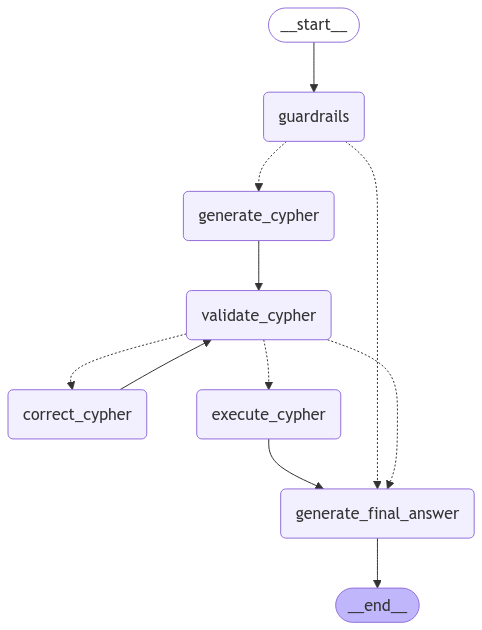

In [158]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

### m. Invoke the workflow

In [130]:
langgraph.invoke({"question": "What's the weather in India?"})

{'answer': "I'm unable to provide information about the weather in India.",
 'steps': ['guardrail', 'generate_final_answer']}

In [159]:
langgraph.invoke({"question": "What was the cast of the Casino?"})

Missing value mapping for Person on property name with value 


{'answer': 'The cast of "Casino" includes Robert De Niro, Sharon Stone, Joe Pesci, James Woods, and Don Rickles, among others.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name"}

In [160]:
langgraph.invoke({"question": "Who was the director of Jumanji?"})

Missing value mapping for Person on property name with value d.name


{'answer': 'The director of Jumanji is Joe Johnston.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (d:Person)-[:DIRECTED]->(m:Movie {title: 'Jumanji'}) RETURN d.name"}

In [161]:
langgraph.invoke({"question": "What is the genre of Father of the Bride Part II?"})

Missing value mapping for Genre on property name with value 


{'answer': 'The genre of "Father of the Bride Part II" is comedy.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Father of the Bride Part II'})-[:IN_GENRE]->(g:Genre) RETURN g.name"}

In [162]:
langgraph.invoke({"question": "Who were the actors in  Father of the Bride Part II?"})

Missing value mapping for Person on property name with value 


{'answer': 'The actors in "Father of the Bride Part II" include Steve Martin, Diane Keaton, Martin Short, Kimberly Williams-Paisley, and George Newbern.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Father of the Bride Part II'})<-[:ACTED_IN]-(a) RETURN a.name"}

In [163]:
langgraph.invoke({"question": "What is the imdb rating of Casino?"})

{'answer': 'The IMDb rating of "Casino" is 8.2.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'}) RETURN m.imdbRating"}

In [164]:
langgraph.invoke({"question": "What is the imdb rating of Now and Then?"})

{'answer': 'The IMDb rating of "Now and Then" is 6.7.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Now and Then'}) RETURN m.imdbRating"}

In [166]:
langgraph.invoke({"question": "What is the imdb rating of Dead Man Walking?"})

{'answer': 'The IMDb rating of "Dead Man Walking" is 7.6.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Dead Man Walking'}) RETURN m.imdbRating"}